Starting from the one-vs-rest model presented in the previous article. The output layer (light red) can be separated into two sublayers as shown below:

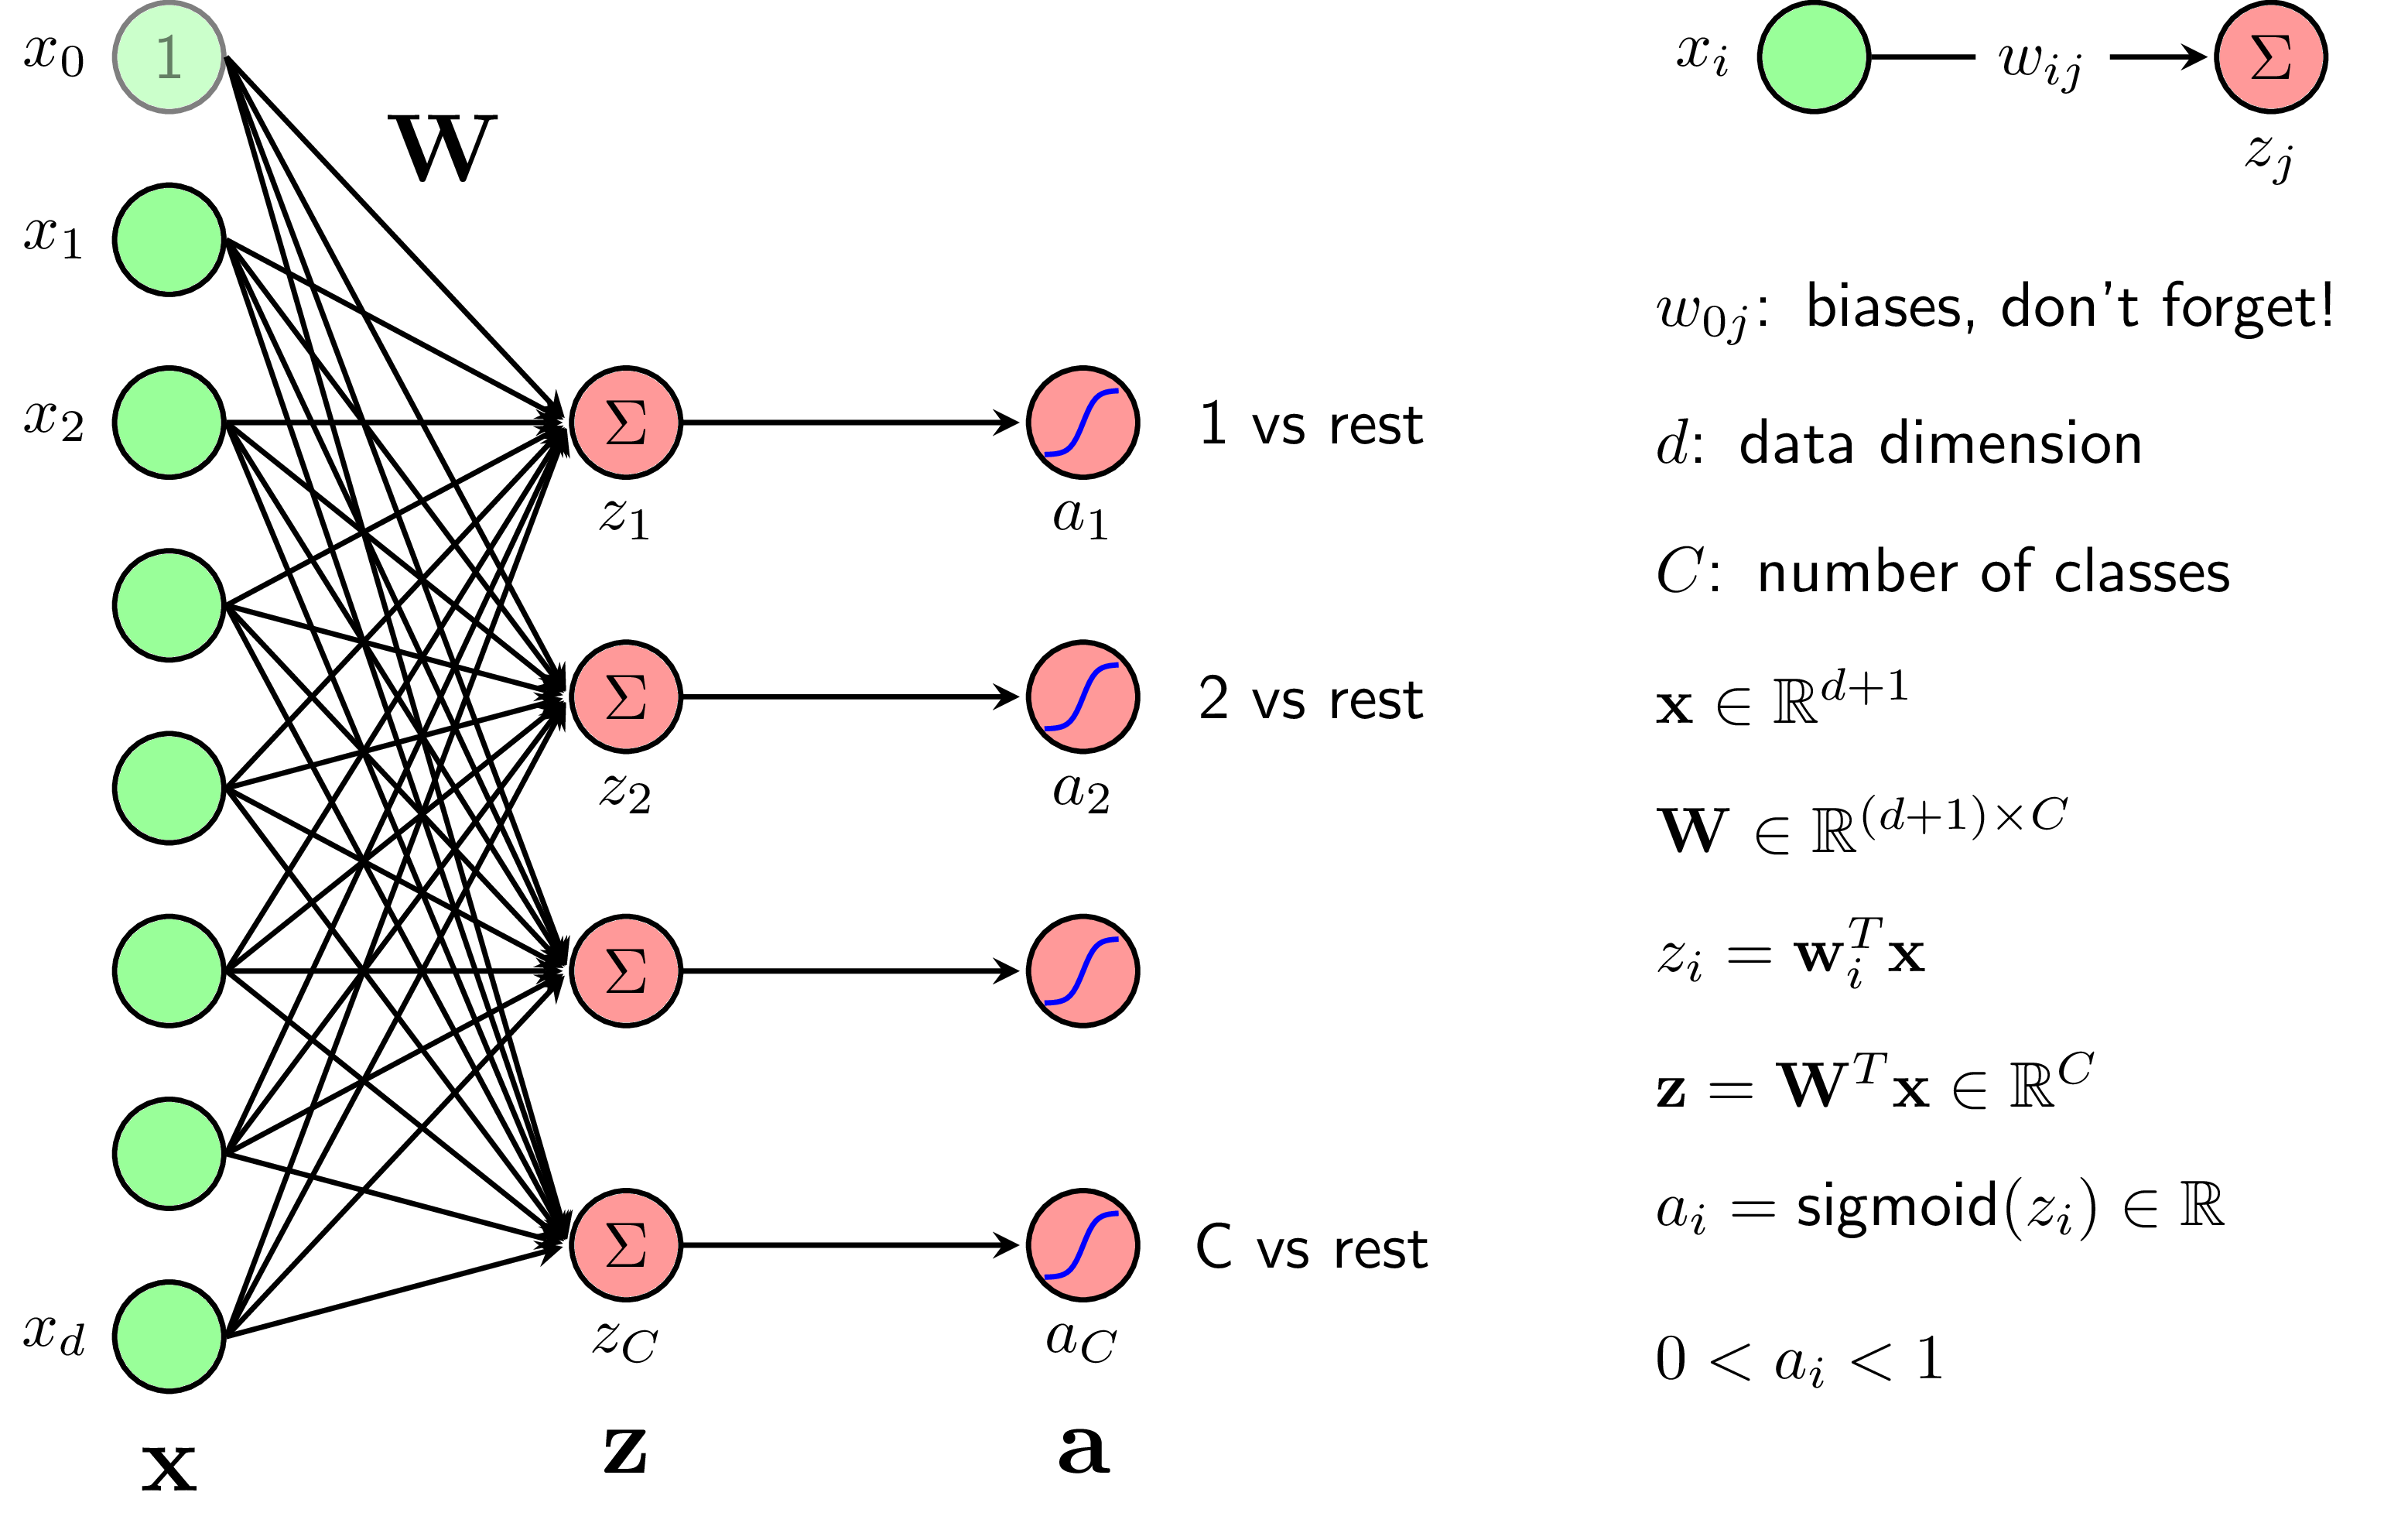

The data $\mathbf{x}$ has dimension $(d + 1)$ because there is an element 1 added to the front, representing the free coefficients in the linear function.

Suppose the number of classes is $C$. With one-vs-rest, we need to build $C$ Logistic Regression differently. The prediction outputs are calculated according to the sigmoid function:

$$a_i = \text{sigmoid}(z_i) = \text{sigmoid}(\mathbf{w}_i^T\mathbf{x})$$

In this technique, the elements $a_i, i = 1, 2, \dots, C$ are derived directly with just $z_i$. Therefore, there is no strict relationship between $a_i$, meaning their sum can be less than or greater than 1. If we can exploit each relationship between $z_i$, the result of the article is classification math could be better.

Note that the Linear Regression, PLA, Logistic Regression models only have 1 node in the output layer. In those cases, the model parameter is just a vector $\mathbf{w}$. In case the output layer has more than 1 node, the model parameters will be the set of parameters $\mathbf{w}_i$ corresponding to each node. At this point, we have the weight matrix $\mathbf{W} = [\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_C]$.

# Softmax function

We need a probability model such that for each input $\mathbf{x}, a_i$ represents the probability that that input falls into class $i$. So the necessary condition is that $a_i$ must be positive and their sum equal to 1. To be able to satisfy this condition, we need to look at every value of $z_i$ and based on the relationship between these $z_i$ to calculate the value of $a_i$. In addition to the conditions that $a_i$ is greater than 0 and has a sum of 1, we will add another very natural condition, which is: value $z_i = \mathbf{w}_i^T\mathbf{x}$ the larger it is, the higher the probability of data falling into class $i$. This last condition shows that we need a covariant function here.

Note that $z_i$ can take both positive and negative values. A simple smooth function that can certainly turn $z_i$ into a positive, and moreover, uniform value, is the function $\exp(z_i) = e^{z_i}$. Smooth condition to make it easier to calculate derivatives later. The final condition, the sum of $a_i$ equal to 1 can be guaranteed if:

$$a_i = \frac{\exp(z_i)}{\displaystyle\sum_{j=1}^C \exp(z_j)}, ~~ \forall i = 1, 2, \dots, C$$

This function, calculating all $a_i$ based on all $z_i$, satisfies all the considered conditions: positive, sum equal to 1, preserving the order of $z_i$. This function is called _softmax function_. Note that with this definition, there is no probability that $a_i$ is absolutely 0 or 1, although they can be very close to 0 or 1 when $z_i$ is very small or very large when compared with the $z_j, j \neq i$.

At this point, we can assume that:

$$\mathbb{P}(y_k = i | \mathbf{x}_k; \mathbf{W}) = a_i$$

In which, $\mathbb{P}(y = i | \mathbf{x}; \mathbf{W})$ is understood as the probability that a data point $\mathbf{x}$ falls into the $i^{\text{th}}$ class if we know the model parameter (weight matrix) is $\mathbf{W}$.

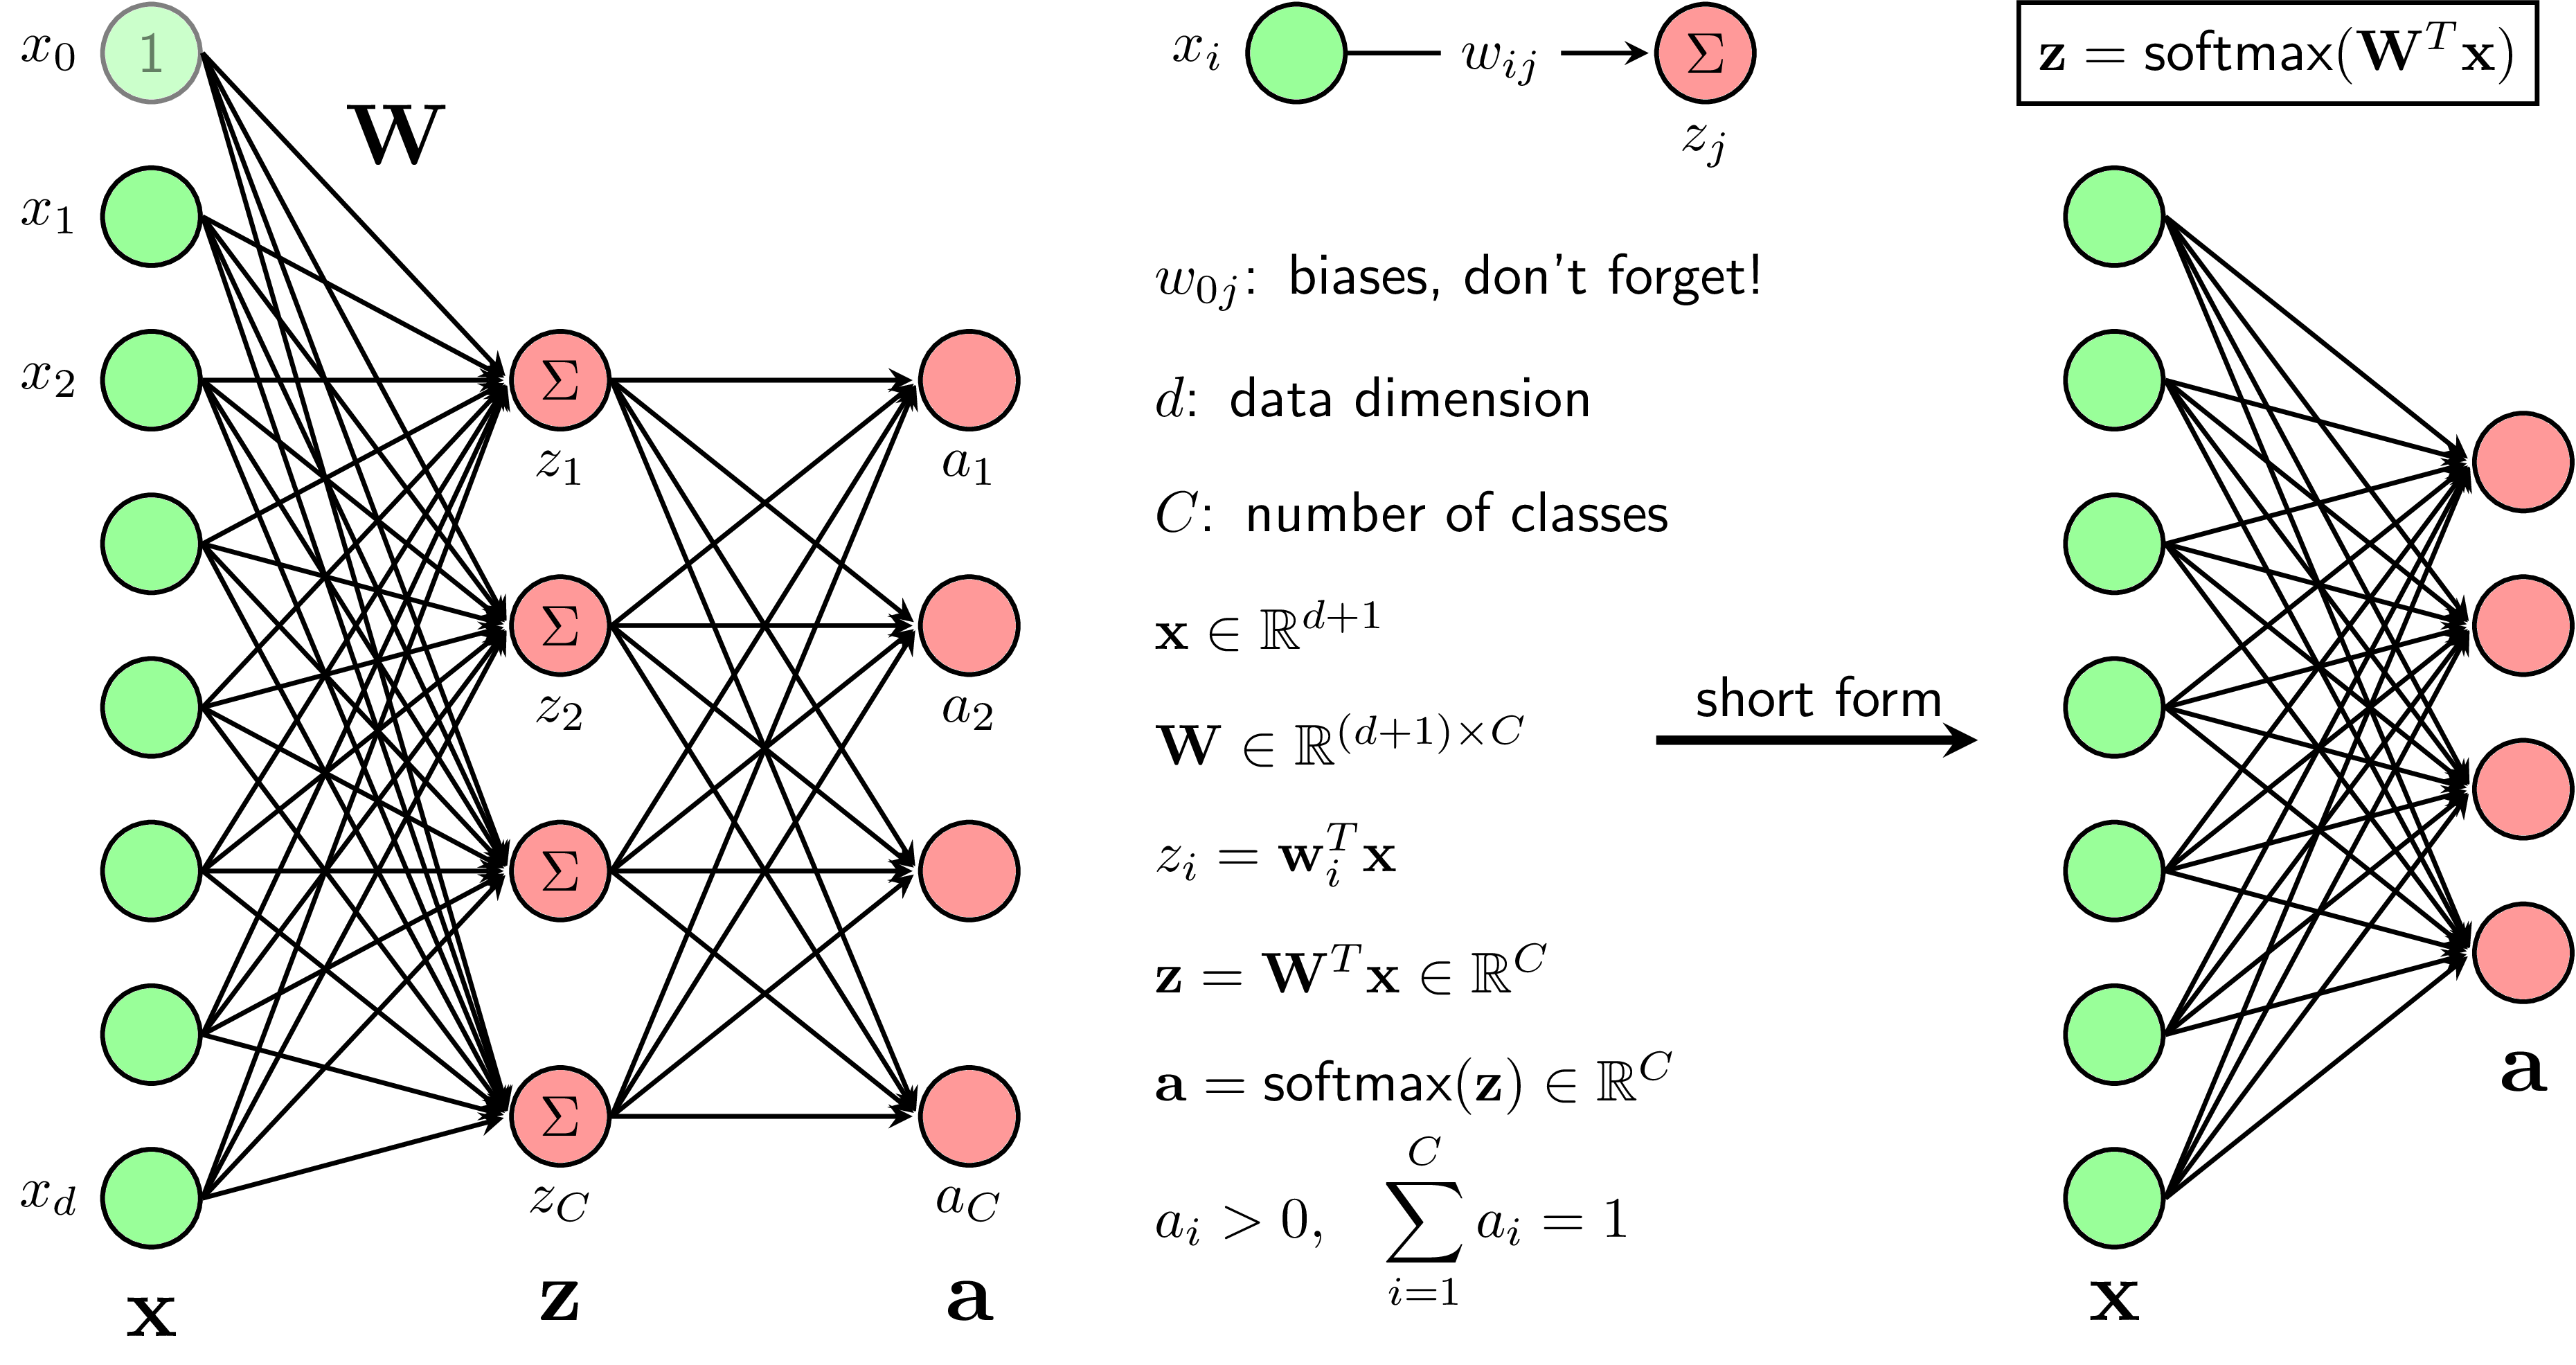

In [1]:
import numpy as np

def softmax(z):
    e_z = np.exp(z)
    return e_z / e_z.sum(axis=0)

## More stable version of softmax function

When one of $z_i$ is too large, calculating $\exp(z_i)$ can cause overflow, greatly affecting the results of the softmax function. There is a way to overcome this phenomenon by relying on the following observation:

$$
\begin{align*}
    a_i &= \frac{\exp(z_i)}{\sum_{j=1}^C \exp(z_j)}\\
    &= \frac{\exp(-c)\exp(z_i)}{\exp(-c)\sum_{j=1}^C \exp(z_j)}\\
    &= \frac{\exp(z_i-c)}{\sum_{j=1}^C \exp(z_j-c)}
\end{align*}
$$

where $c$ is any constant.

So a simple method to help overcome the overflow phenomenon is to subtract all $z_i$ by a large enough value. In practice, this large enough value is often chosen as $c = \max_i z_i$.

In [2]:
def softmax_stable(z):
    e_z = np.exp(z - np.max(z, axis=0, keepdims = True)) # `keepdims = True` to ensure the subtraction between the Z matrix and the vector works.
    return e_z / e_z.sum(axis=0)

# Loss function and optimization method

## Introduction to Cross entropy

Cross entropy between two distributions $\mathbf{p}$ and $\mathbf{q}$ is defined as:

$$H(\mathbf{p}, \mathbf{q}) = -\sum_{i=1}^C p_i\log(q_i)\tag{1}$$

With $\mathbf{p}$ and $\mathbf{q}$ being discrete (like $\mathbf{y}$ and $\mathbf{a}$ in our problem).

To better understand the advantages of the cross entropy function and the normal squared distance function, let's look at figure below. This is an example in the case where $C = 2$ and $p_1$ receive the values $0.5, 0.1$ and $0.8$ respectively. Note that $p_2 = 1 − p_1$.

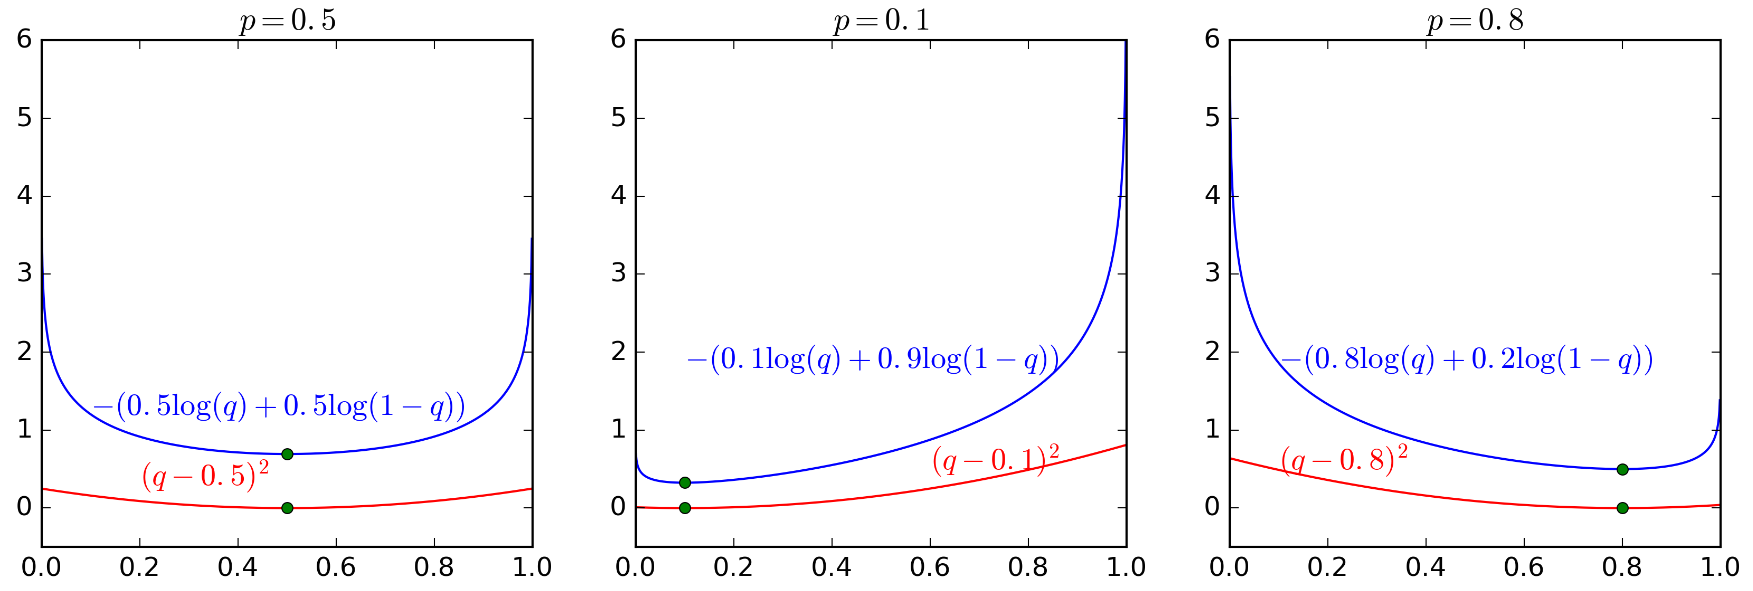

There are two important observations below:

+ The smallest value of both functions is achieved when $q = p$ at the coordinates of the green points.
+ More importantly, the cross entropy function takes a very high value (i.e. very high loss) when $q$ is far from $p$. Meanwhile, the difference between losses near or far from the solution of the squared distance function $(q - p)^2$ is less significant. Optimally, the cross entropy function will give solutions closer to $p$ because solutions far away are severely punished.

$\text{Note:}$

1. The cross entropy function has no symmetry $H(\mathbf{p}, \mathbf{q}) \neq H(\mathbf{q}, \mathbf{p})$. This can be easily seen in the fact that the components of $\mathbf{p}$ in formula $(1)$ can take on the value $0$, while the components of $\mathbf{q}$ must be positive because $\log(0)$ is undefined. Therefore, when using cross entropy in classification problems, $\mathbf{p}$ is the real output because it is a vector in one-hot form, $\mathbf{q}$ is the predicted output. Among the components representing the probability of $\mathbf{q}$, there is no component that is absolutely equal to $1$ or absolutely equal to $0$ (because the exp function always returns a positive value).
2. When $\mathbf{p}$ is a vector in one-hot form, assuming only $p_c = 1$, then the cross entropy expression becomes $−\log(q_c)$. This expression reaches its minimum value if $q_c = 1$, which is not feasible because this solution does not belong to the domain of the problem. However, the cross entropy value approaches $0$ as $q_c$ approaches $1$. This happens when $z_c$ is very, very large compared to the remaining $z_i$.
3. In [Logistic Regression](https://github.com/letruongzzio/Machine-Learning/tree/main/5%20-%20Neural%20Networks/Logistic%20Regression), we also have two simple distributions:
 
    + The actual output of the input data point $\mathbf{x}_i$ has a probability distribution of $[y_i; 1 - y_i]$ where $y_i$ is the probability that the input data point falls into the first class (equal to $1$ if $y_i = 1$, equal to $0$ if $y_i = 0$).
    + The predicted output of that data point is $a_i = \text{sigmoid}(\mathbf{w}^T\mathbf{x})$ which is the probability that that point falls into the first class. The probability that the point falls into the second class can be easily derived as $1 - a_i$. So, the loss function in Logistic Regression:

$$J(\mathbf{w}) = -\sum_{i=1}^N(y_i \log {a}_i + (1-y_i) \log (1 - {a}_i))$$

## Build the loss function

In Softmax Regression, in the case of $C$ classes, the loss between the predicted output and the actual output of a data point $\mathbf{x}$ is calculated by:

$$J_i(\mathbf{W}) := J(\mathbf{W};\mathbf{x}_i, \mathbf{y}_i) = -\sum_{j=1}^C y_{ji}\log(a_{ji})\tag{2}$$

With $y_{ji}$ and $a_{ji}$ being the $j^{th}$ element of the (probability) vector $\mathbf{y}_i$ and $\mathbf{a}_i$, respectively. Recall that the output $\mathbf{a}_i$ depends on the input $\mathbf{x}_i$ and the weight matrix $\mathbf{W}$.

Combining all data pairs $\mathbf{x}_i, \mathbf{y}_i , i = 1, 2, \ldots, N$, the loss function for softmax regression is determined by:

$$
\begin{align*}
    J(\mathbf{W}; \mathbf{X}, \mathbf{Y}) &= -\frac{1}{N}\sum_{i = 1}^N \sum_{j = 1}^C y_{ji}\log(a_{ji})\\
    &= -\frac{1}{N}\sum_{i = 1}^N \sum_{j = 1}^C y_{ji}\log\left(\frac{\exp(\mathbf{w}_j^T\mathbf{x}_i)}{\sum_{k=1}^C \exp(\mathbf{w}_k^T\mathbf{x}_i)}\right)
\end{align*}
$$

Since the one-hot label vector $\mathbf{y}_i$ has only one position equal to $1$, let that position be $j = \overline{j}$. Then $\sum_{j = 1}^C y_{ji}\log(a_{\overline{j} i}) = \log(a_{\overline{j} i})$, so we have the loss function $J( \mathbf{W}; \mathbf{X}, \mathbf{Y})$ looks less confusing like this:

$$
\begin{align*}
    J(\mathbf{W}; \mathbf{X}, \mathbf{Y}) &= -\frac{1}{N}\sum_{i = 1}^N \log(a_{\overline{j} i})\\
    &= -\frac{1}{N}\sum_{i = 1}^N \log\left(\frac{\exp(\mathbf{w}_{\overline{j}}^T\mathbf{x}_i)}{\sum_{k=1}^C \exp(\mathbf{w}_k^T\mathbf{x}_i)}\right)
\end{align*}
$$

Here, the weight matrix $\mathbf{W}$ is the variable that needs to be optimized. Although this loss function looks complicated, its derivative is very neat. We can also add weight decay to avoid overfitting by adding a quantity proportional to $||\mathbf{W}||_F^2$.

$$\overline{J}(\mathbf{W}; \mathbf{X}, \mathbf{Y}) = -\frac{1}{N}\sum_{i = 1}^N \left(\log(a_{\overline{j} i}) + \frac{\lambda}{2}||\mathbf{W}||_F^2\right)$$

In [3]:
def softmax_loss(X, Y, W, lamb=0.001):
    """
    W: 2d numpy array of shape (d, C), each column corresponding to one output node
    X: 2d numpy array of shape (N, d), each row is one data point
    y: 1d numpy array -- label of each row of X 
    """
    A = softmax_stable((W.T.dot(X)))
    return -np.mean(Y*np.log(A) + lamb/2 * np.sum(W * W))

def softmax_cost(X, Y, W, lamb=0.001):
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

## Optimize the loss function

The loss function will be optimized using gradient descent, specifically mini-batch gradient descent. Each update of mini-batch gradient descent is performed on a batch with number of elements $1 < k \ll N$. To calculate the derivative of the loss function with respect to this subset, we first consider the derivative of the loss function at a data point.

For each pair of data $(\mathbf{x}_i, \mathbf{y}_i)$ we have:

$$
\begin{align*}
    J_i(\mathbf{W}) &:=& J(\mathbf{W}; \mathbf{x}_i, \mathbf{y}_i)\\
    &=& -\sum_{j = 1}^C y_{ji}\log\left(\frac{\exp(\mathbf{w}_j^T\mathbf{x}_i)}{\sum_{k=1}^C \exp(\mathbf{w}_k^T\mathbf{x}_i)}\right) \\
    &=& -\sum_{j=1}^C\left(y_{ji} \mathbf{w}_j^T\mathbf{x}_i - y_{ji}\log\left(\sum_{k=1}^C \exp(\mathbf{w}_k^T\mathbf{x}_i)\right)\right) \\
    &=& -\sum_{j=1}^C y_{ji} \mathbf{w}_j^T\mathbf{x}_i + \log\left(\sum_{k=1}^C \exp(\mathbf{w}_k^T\mathbf{x}_i)\right)\tag{3}
\end{align*}
$$

Next we use the formula:

$$\frac{\partial J_i(\mathbf{W})}{\partial \mathbf{W}} = \left[\frac{\partial J_i(\mathbf{W})}{\partial \mathbf{w}_1}, \frac{\partial J_i(\mathbf{W})}{\partial \mathbf{w}_2}, \dots, \frac{\partial J_i(\mathbf{W})}{\partial \mathbf{w}_C}\right]\tag{4}$$

In which, the gradient in each column of $w_j$ can be calculated based on:

$$
\begin{align*}
    \frac{\partial J_i(\mathbf{W})}{\partial \mathbf{w}_j} &=& -y_{ji}\mathbf{x}_i + 
    \frac{\exp(\mathbf{w}_j^T\mathbf{x}_i)}{\sum_{k = 1}^C \exp(\mathbf{w}_k^T\mathbf{x}_i)}\mathbf{x}_i \\
    &=& -y_{ji}\mathbf{x}_i + a_{ji} \mathbf{x}_i = \mathbf{x}_i (a_{ji} - y_{ji}) \\
    &=& e_{ji}\mathbf{x}_{i}\tag{5}
\end{align*}
$$

The value $e_{ji} = a_{ji} - y_{ji}$ is the difference between the predicted output and the actual output at the $j^{th}$ component (also known as the prediction error). Combining $(4)$ and $(5)$ with $\mathbf{e}_i = \mathbf{a}_i - \mathbf{y}_i$ we have:

$$
\frac{\partial J_i(\mathbf{W})}{\partial \mathbf{W}} = \mathbf{x}_i [e_{1i}, e_{2i}, \dots, e_{Ci}] = \mathbf{x}_i\mathbf{e}_i^T\\
\Rightarrow\frac{\partial J(\mathbf{W})}{\partial \mathbf{W}} = \sum_{i=1}^N \mathbf{x}_i\mathbf{e}_i^T = \mathbf{X}\mathbf{E}^T
$$

with $\mathbf{E} = \mathbf{A} - \mathbf{Y}$. This simple derivative formula makes it possible for both batch gradient descent and mini-batch gradient descent to be easily applied. In the case of gradient mini-batch, assume the batch size is $k$, denoted $\mathbf{X}_b\in\mathbb{R}^{d\times k}, \mathbf{Y}_b\in\{0, 1\}^{C\times k}, \mathbf{A}_b\in\mathbb{R}^{C\times k}$ is the data corresponding to a batch, the update formula for a batch will be:

$$\mathbf{W}\leftarrow\mathbf{W} - \frac{\eta}{N_b}\mathbf{X}_b\mathbf{E_b}^T$$

where $N_b$ is the size of each batch.

## Check the derivative

### Create the data

Machine Learning problems are often highly complex with large amounts of data and many dimensions. To be able to apply an algorithm to a specific problem, we first need to apply that algorithm to simulated data (fake data) with a smaller number of dimensions and data points. This simulated data is usually generated randomly (some constraints may be added depending on the characteristics of the data). With small simulated data, we can debug faster and try with many different simulated data cases. Only when we see that the algorithm runs correctly will we put real data in.

With Softmax Regression, I create simulated data as follows:

In [4]:
import numpy as np
np.random.seed(42)

# randomly generate data 
N = 2 # number of training sample 
d = 2 # data dimension 
C = 3 # number of classes 

X = np.random.randn(d, N)
y = np.random.randint(0, C, N)

In [5]:
X

array([[ 0.49671415, -0.1382643 ],
       [ 0.64768854,  1.52302986]])

In [6]:
y

array([2, 1])

### One-hot coding matrix

There is another important step in Softmax Regression which is to convert each label $y_i$ into a vector $\mathbf{y}_i$ as one-hot coding. In which, there is only one element of $\mathbf{y}_i$ equal to $1$, the remaining elements equal $0$. Thus, for $N$ data points and $C$ classes, we will have a matrix of size $C\times N$ in which each column has exactly 1 element equal to $1$, the rest equal to $0$. If we save all this data, it will be a waste of memory.

Python have [scipy.sparse.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) to help us practicing this work.

In [7]:
from scipy import sparse 
def convert_labels(y, C = C):
    """
    convert 1d label to a matrix label: each column of this 
    matrix corresponding to 1 element in y. In i-th column of Y, 
    only one non-zeros element located in the y[i]-th position, 
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y 

Y = convert_labels(y, C)
Y

array([[0, 0],
       [0, 1],
       [1, 0]])

### Check the derivative

The function to calculate the derivative with respect to $\mathbf{W}$ in Python can be implemented as follows:

In [8]:
def softmax_grad(X, Y, W):
    A = softmax_stable((W.T.dot(X)))
    E = A - Y
    return X.dot(E.T)

The key to optimizing the loss function is calculating the gradient. With math expressions that look quite confusing like the one above, it's easy for you to get confused at a certain step. In practice, a common way to do this is to compare the calculated gradient with the numeric gradient, which is the gradient calculated by definition:

In [9]:
W_init = np.random.randn(d, C)

def numerical_grad(X, Y, W, cost, eps=1e-6):
    g = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_p = W.copy()
            W_n = W.copy()
            W_p[i, j] += eps 
            W_n[i, j] -= eps
            g[i,j] = (cost(X, Y, W_p) - cost(X, Y, W_n))/(2*eps)
    return g 

g1 = softmax_grad(X, Y, W_init)
g2 = numerical_grad(X, Y, W_init, softmax_cost)

print(np.linalg.norm(g1 - g2))

3.355870691884752e-10


### Main function for training Softmax Regression

In [10]:
def softmax_fit(X, Y, W_init, lr = 0.01, n_epochs = 100, tol = 1e-5, batch_size = 10):
    W = [W_init]
    loss_hist = [softmax_loss(X, Y, W[-1])] # store history of loss 
    N = X.shape[1]
    n_batches_per_epoch = int(np.ceil(float(N)/batch_size)) # number of batches per epoch
    for epoch in range(n_epochs):
        shuffled_indices = np.random.permutation(N) # mix data 
        X_shuffled = X.T[shuffled_indices]
        Y_shuffled = Y.T[shuffled_indices]
        for iteration in range(0, n_batches_per_epoch):
            # get the i-th batch
            batch_ids = shuffled_indices[batch_size * iteration : min(batch_size * (iteration + 1), N)] 
            xi = X_shuffled[batch_ids]
            yi = Y_shuffled[batch_ids]
            W_new = W[-1] - lr * softmax_grad(xi.T, yi.T, W[-1]) # update gradient descent 
            loss_hist.append(softmax_loss(X, Y, W_new))
            if np.linalg.norm(W_new - W[-1])/W_new.size < tol:
                break 
            W.append(W_new)
    return W, loss_hist

In [11]:
def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

# Example on Python

## With 3-dimensional space

In [12]:
d = 100
C = 3 
N = 3000
X = np.random.randn(d, N)
y = np.random.randint(0, C, N)
W = np.random.randn(d, C) 

Y = convert_labels(y, C)

In [13]:
W, loss_hist = softmax_fit(X, Y, W, batch_size=100)

0.37499181847221436


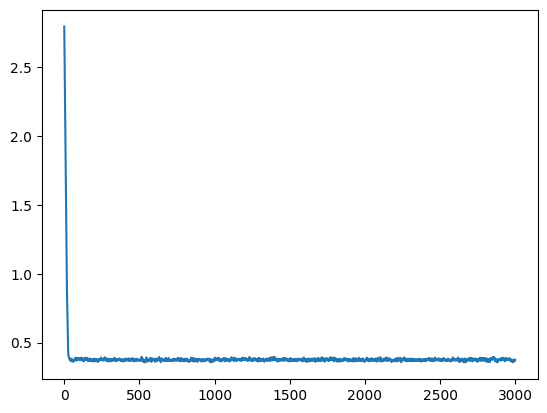

In [14]:
import matplotlib.pyplot as plt

print(loss_hist[-1])
plt.plot(loss_hist)
plt.show()

## With 5-dimensional space

In [15]:
C = 5    # number of classes
N = 500  # number of points per class 
means = [[2, 2], [8, 3], [3, 6], [14, 2], [12, 8]]
cov = [[1, 0], [0, 1]]

X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
X3 = np.random.multivariate_normal(means[3], cov, N)
X4 = np.random.multivariate_normal(means[4], cov, N)

X = np.concatenate((X0, X1, X2, X3, X4), axis=0) # each row is a datapoint
Xbar = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # bias trick 

y = np.asarray([0]*N + [1]*N + [2]*N+ [3]*N + [4]*N)
Y = convert_labels(y, C)

In [16]:
W_init = np.random.randn(Xbar.shape[1], C)
W, loss_hist = softmax_fit(Xbar.T, Y, W_init, lr = 0.01, n_epochs = 100, batch_size = 10)

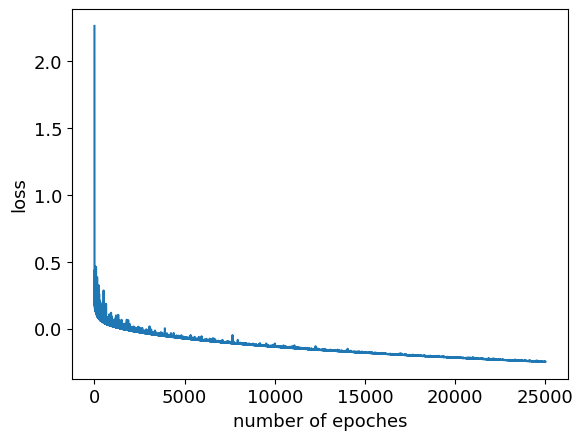

In [17]:
plt.plot(loss_hist)
plt.xlabel('number of epoches', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show() 

In [18]:
xm = np.arange(-2, 18, 0.025)
xlen = len(xm)
ym = np.arange(-3, 11, 0.025)
ylen = len(ym)
xx, yy = np.meshgrid # meshgrid: generates a gro



ffff ints for plotting

# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# xx.ravel(), yy.ravel()

print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(-1, 1) # Why do you use `ravel().reshape(-1, 1)`? Ans: To convert the 2D array to 1D array and then reshape it to a column vector.
yy1 = yy.ravel().reshape(-1, 1)

# print(xx.shape, yy.shape)
XX = np.concatenate((xx1, yy1, np.ones((xx.size, 1))), axis = 1)

print(XX.shape)

(1, 448000)
(448000, 3)


In [19]:
Z = [pred(W[-1], x) for x in XX]
Z = np.array(Z)
Z.shape

(448000,)

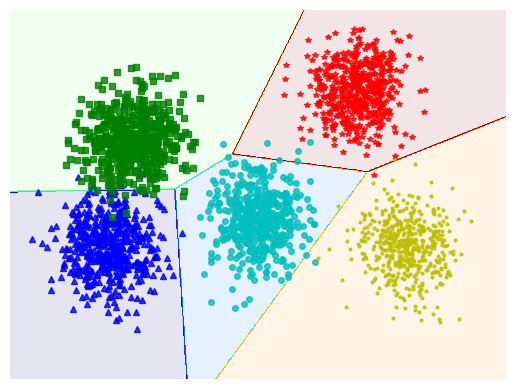

In [20]:
import matplotlib.pyplot as plt

def display(X, label):
    X0 = X[np.where(label == 0)[0]]
    X1 = X[np.where(label == 1)[0]]
    X2 = X[np.where(label == 2)[0]]
    X3 = X[np.where(label == 3)[0]]
    
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'co', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'gs', markersize = 4, alpha = .8)
    plt.plot(X3[:, 0], X3[:, 1], 'y.', markersize = 4, alpha = .8)
    plt.plot(X4[:, 0], X4[:, 1], 'r*', markersize = 4, alpha = .8)

    plt.axis('off')
    plt.plot()
    

Z = Z.reshape(xx.shape)
CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha = .1)

plt.xlim(-2, 18)
plt.ylim(-3, 11)
plt.xticks(())
plt.yticks(())
display(X, y)
plt.show()

## MNIST

In scikit-learn, softmax regression is integrated in the `sklearn.linear_model.LogisticRegression` class. As will be seen in the discussion, logistic regression is softmax regression for the binary classification problem. For multi-class classification problems, this library uses the one-vs-rest technique by default. To use softmax regression, we change the properties `multi_class = 'multinomial'` and `solver = 'lbfgs'`. Here, `'lbfgs'` is a very powerful optimization method also based on derivatives.

In [21]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mnist = fetch_openml('mnist_784', as_frame=False)

X = mnist.data 
y = mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

model = LogisticRegression(C = 1e5, solver = 'lbfgs', multi_class = 'multinomial') # C is inverse of lam 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy %.2f %%" % (100*accuracy_score(y_test, y_pred.tolist())))

Accuracy 92.05 %


/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Compared with the result of more than 91.7% of one-vs-rest logistic regression, the result of softmax regression has been slightly improved. Low results like this are predictable because in fact softmax regression still only produces boundaries that are linear. The best result of the number classification problem in MNIST currently is about more than 99.7%, achieved by a convolutional neural network with many hidden layers and the last layer is a softmax regression.

# Expand knowledges

## Logistic regression is a special case of softmax regression

When $C = 2$, softmax regression and logistic regression are the same. Indeed, for $C = 2$, the output of the softmax function for an input $\mathbf{x}$ is:

$$a_1 = \frac{\exp(\mathbf{w}_1^T\mathbf{x})}{\exp(\mathbf{w}_1^T\mathbf{x}) + \exp(\mathbf{w}_2^T\mathbf{x})} = \frac{1}{1 + \exp((\mathbf{w}_2 - \mathbf{w}_1)^T\mathbf{x})} \ ; \ a_2 = 1 - a_1$$

From here we see that $a_1$ has the form of a sigmoid function with coefficient vector $\mathbf{w} = −(\mathbf{w}_2 − \mathbf{w}_1)$.

## The boundary created by softmax regression is a linear surface

Indeed, based on the softmax function, a data point $\mathbf{x}$ is predicted to fall into class $j$ if $a_j\geq a_k, \forall k \neq j$. We can prove it as follows:

$$a_j\geq a_k\Leftrightarrow z_j\geq z_k\Leftrightarrow\mathbf{w}_j^T\mathbf{x}\geq\mathbf{w}_k^T\mathbf{x}\Leftrightarrow (\mathbf{w}_j - \mathbf{w}_k)^T\mathbf{x}\geq 0$$

Thus, the territory of each data layer is the intersection of the half-spaces. In other words, the boundaries between layers are linear surfaces.

___
## **References:**

$[1].$ Hữu Vũ, T. (2018). _Machine Learning cơ bản_ (Vol. 15), Nhà xuất bản khoa học và kỹ thuật.